In [1]:
# ===== IMPORTS =====
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
import warnings
warnings.filterwarnings("ignore")

In [2]:
# ===== NEURAL NETWORK CLASS =====
class NeuralNetwork:
    """
    A simple neural network with one hidden layer built from scratch.
    """
    def __init__(self, input_size, hidden_size, output_size, loss_func='mse'):
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.loss_func = loss_func
        
        # Initialize weights and biases with random values
        self.weights1 = np.random.randn(self.input_size, self.hidden_size) * 0.1
        self.bias1 = np.zeros((1, self.hidden_size))
        self.weights2 = np.random.randn(self.hidden_size, self.output_size) * 0.1
        self.bias2 = np.zeros((1, self.output_size))
        
        # Track loss
        self.train_loss = []
        self.test_loss = []
    
    def __str__(self):
        return f"Neural Network Layout:\nInput Layer: {self.input_size} neurons\nHidden Layer: {self.hidden_size} neurons\nOutput Layer: {self.output_size} neurons\nLoss Function: {self.loss_func}"
    
    def forward(self, X):
        """Perform forward propagation"""
        # Hidden layer
        self.z1 = np.dot(X, self.weights1) + self.bias1
        self.a1 = self.sigmoid(self.z1)
        
        # Output layer
        self.z2 = np.dot(self.a1, self.weights2) + self.bias2
        
        # Apply appropriate activation function based on loss
        if self.loss_func == 'categorical_crossentropy':
            self.a2 = self.softmax(self.z2)
        else:
            self.a2 = self.sigmoid(self.z2)
        
        return self.a2
    
    def backward(self, X, y, learning_rate):
        """Perform backpropagation and update weights"""
        m = X.shape[0]  # Number of samples
        
        # Calculate output layer gradients
        if self.loss_func == 'mse':
            self.dz2 = self.a2 - y
        elif self.loss_func == 'log_loss':
            self.dz2 = -(y/self.a2 - (1-y)/(1-self.a2))
        elif self.loss_func == 'categorical_crossentropy':
            self.dz2 = self.a2 - y
        else:
            raise ValueError('Invalid loss function')
        
        # Calculate gradients for output layer
        self.dw2 = (1 / m) * np.dot(self.a1.T, self.dz2)
        self.db2 = (1 / m) * np.sum(self.dz2, axis=0, keepdims=True)
        
        # Calculate gradients for hidden layer
        self.dz1 = np.dot(self.dz2, self.weights2.T) * self.sigmoid_derivative(self.a1)
        self.dw1 = (1 / m) * np.dot(X.T, self.dz1)
        self.db1 = (1 / m) * np.sum(self.dz1, axis=0, keepdims=True)
        
        # Update weights and biases
        self.weights2 -= learning_rate * self.dw2
        self.bias2 -= learning_rate * self.db2
        self.weights1 -= learning_rate * self.dw1
        self.bias1 -= learning_rate * self.db1
    
    def sigmoid(self, x):
        """Sigmoid activation function"""
        return 1 / (1 + np.exp(-np.clip(x, -250, 250)))  # Clip to prevent overflow
    
    def sigmoid_derivative(self, x):
        """Derivative of sigmoid function"""
        return x * (1 - x)
    
    def softmax(self, x):
        """Softmax activation function"""
        exps = np.exp(x - np.max(x, axis=1, keepdims=True))  # Stability trick
        return exps / np.sum(exps, axis=1, keepdims=True)

In [3]:
# ===== TRAINER CLASS =====
class Trainer:
    """Class to train the neural network"""
    def __init__(self, model, loss_func='mse'):
        self.model = model
        self.loss_func = loss_func
        self.train_loss = []
        self.test_loss = []
    
    def calculate_loss(self, y_true, y_pred):
        """Calculate loss based on specified loss function"""
        if self.loss_func == 'mse':
            return np.mean((y_pred - y_true)**2)
        elif self.loss_func == 'log_loss':
            # Add small epsilon to prevent log(0)
            epsilon = 1e-15
            y_pred = np.clip(y_pred, epsilon, 1 - epsilon)
            return -np.mean(y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred))
        elif self.loss_func == 'categorical_crossentropy':
            epsilon = 1e-15
            y_pred = np.clip(y_pred, epsilon, 1 - epsilon)
            return -np.mean(np.sum(y_true * np.log(y_pred), axis=1))
        else:
            raise ValueError('Invalid loss function')
    
    def train(self, X_train, y_train, X_test, y_test, epochs, learning_rate):
        """Train the neural network"""
        print(f"Training Neural Network for {epochs} epochs...")
        
        for epoch in range(epochs):
            # Forward and backward pass on training data
            self.model.forward(X_train)
            self.model.backward(X_train, y_train, learning_rate)
            
            # Calculate training loss
            train_pred = self.model.forward(X_train)
            train_loss = self.calculate_loss(y_train, train_pred)
            self.train_loss.append(train_loss)
            
            # Calculate test loss
            test_pred = self.model.forward(X_test)
            test_loss = self.calculate_loss(y_test, test_pred)
            self.test_loss.append(test_loss)
            
            # Print progress every 100 epochs
            if epoch % 100 == 0:
                print(f"Epoch {epoch}: Train Loss = {train_loss:.4f}, Test Loss = {test_loss:.4f}")

In [4]:
# ===== LOAD AND EXPLORE DATASET =====
print("📊 Loading Digits Dataset...")
digits = load_digits()

print(f"Dataset shape: {digits.data.shape}")
print(f"Number of classes: {len(np.unique(digits.target))}")
print(f"Classes: {np.unique(digits.target)}")

📊 Loading Digits Dataset...
Dataset shape: (1797, 64)
Number of classes: 10
Classes: [0 1 2 3 4 5 6 7 8 9]



🖼️ Visualizing sample digits...


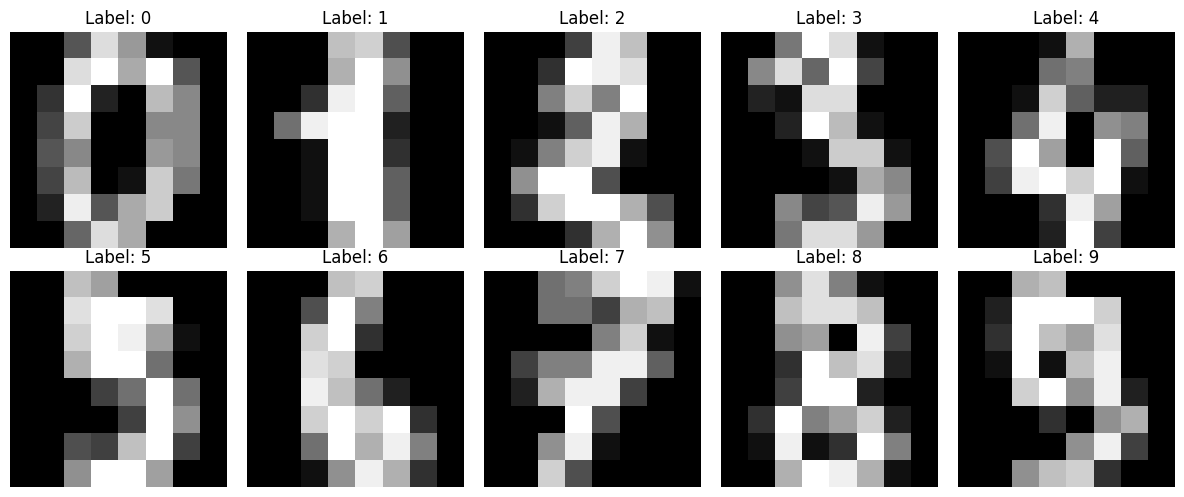

In [5]:
# Visualize first 10 images
print("\n🖼️ Visualizing sample digits...")
fig, axes = plt.subplots(2, 5, figsize=(12, 5))
axes = axes.ravel()

for i in range(10):
    axes[i].imshow(digits.images[i], cmap='gray')
    axes[i].set_title(f"Label: {digits.target[i]}")
    axes[i].axis('off')

plt.tight_layout()
plt.show()

In [6]:
# ===== DATA PREPROCESSING =====
print("\n🧹 Preprocessing data...")

# Normalize features to [0, 1] range
scaler = MinMaxScaler()
X = scaler.fit_transform(digits.data)

# One-hot encode targets
encoder = OneHotEncoder(sparse_output=False)
y_onehot = encoder.fit_transform(digits.target.reshape(-1, 1))

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y_onehot, test_size=0.2, random_state=42
)

print(f"Training set: {X_train.shape}")
print(f"Test set: {X_test.shape}")


🧹 Preprocessing data...
Training set: (1437, 64)
Test set: (360, 64)


In [7]:
# ===== CREATE AND TRAIN NEURAL NETWORK =====
print("\n🔄 Creating Neural Network...")

# Network parameters
input_size = X.shape[1]
hidden_size = 64
output_size = len(np.unique(digits.target))
loss_func = 'categorical_crossentropy'
epochs = 1000
learning_rate = 0.1


🔄 Creating Neural Network...


In [8]:
# Create neural network
nn = NeuralNetwork(input_size, hidden_size, output_size, loss_func)
print(nn)

Neural Network Layout:
Input Layer: 64 neurons
Hidden Layer: 64 neurons
Output Layer: 10 neurons
Loss Function: categorical_crossentropy


In [9]:
# Train neural network
trainer = Trainer(nn, loss_func)
trainer.train(X_train, y_train, X_test, y_test, epochs, learning_rate)

Training Neural Network for 1000 epochs...
Epoch 0: Train Loss = 2.3713, Test Loss = 2.3782
Epoch 100: Train Loss = 2.1467, Test Loss = 2.1581
Epoch 200: Train Loss = 1.9074, Test Loss = 1.9215
Epoch 300: Train Loss = 1.5754, Test Loss = 1.5903
Epoch 400: Train Loss = 1.2385, Test Loss = 1.2490
Epoch 500: Train Loss = 0.9698, Test Loss = 0.9723
Epoch 600: Train Loss = 0.7776, Test Loss = 0.7733
Epoch 700: Train Loss = 0.6423, Test Loss = 0.6341
Epoch 800: Train Loss = 0.5449, Test Loss = 0.5352
Epoch 900: Train Loss = 0.4725, Test Loss = 0.4627


In [10]:
# ===== EVALUATE MODEL =====
print("\n📊 Evaluating Model Performance...")

# Convert one-hot encoded test labels back to integers
y_test_labels = np.argmax(y_test, axis=1)

# Make predictions
predictions = np.argmax(nn.forward(X_test), axis=1)
accuracy = np.mean(predictions == y_test_labels)

print(f"🎯 Final Test Accuracy: {accuracy:.2%}")


📊 Evaluating Model Performance...
🎯 Final Test Accuracy: 91.67%



🔍 Sample Predictions:
True labels: [6 9 3 7 2 1 5 2 5 2]
Predicted:   [6 9 3 7 2 2 5 2 5 2]

📈 Plotting Training Progress...


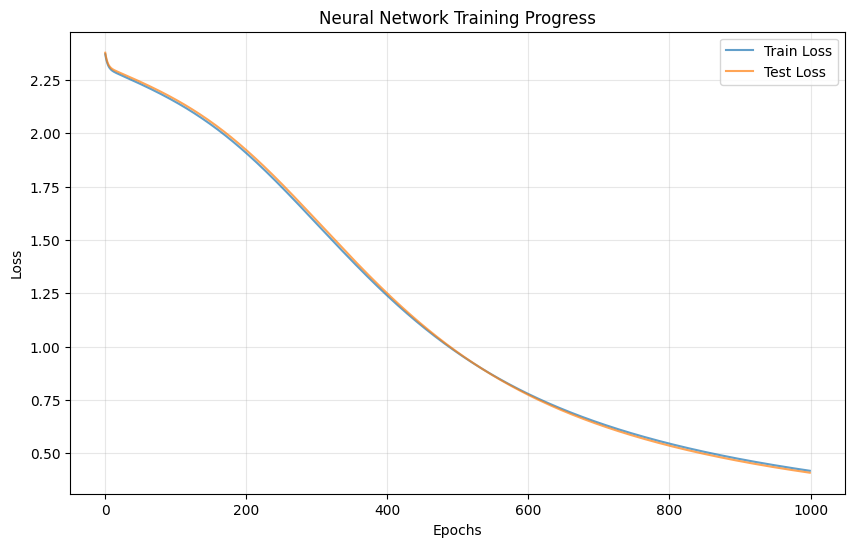

In [11]:
# Display some predictions
print("\n🔍 Sample Predictions:")
print("True labels:", y_test_labels[:10])
print("Predicted:  ", predictions[:10])

# ===== PLOT TRAINING LOSS =====
print("\n📈 Plotting Training Progress...")
plt.figure(figsize=(10, 6))
plt.plot(trainer.train_loss, label='Train Loss', alpha=0.7)
plt.plot(trainer.test_loss, label='Test Loss', alpha=0.7)
plt.title('Neural Network Training Progress')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


📋 Generating Confusion Matrix...


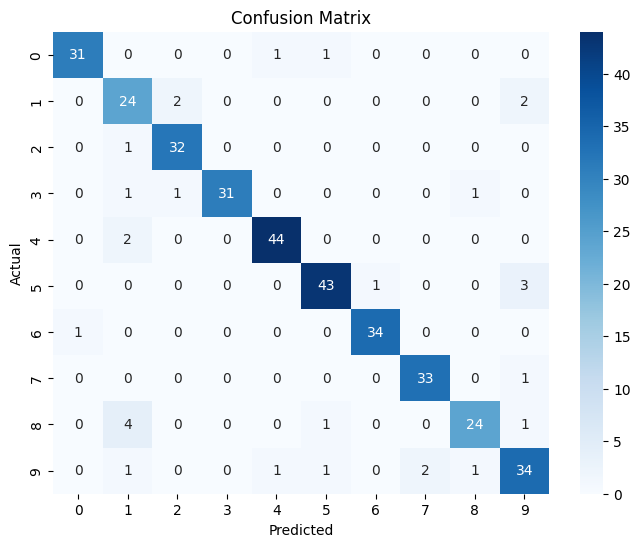

In [12]:
# ===== CONFUSION MATRIX (Optional) =====
print("\n📋 Generating Confusion Matrix...")
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

cm = confusion_matrix(y_test_labels, predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=range(10), yticklabels=range(10))
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [13]:
# Print classification report
print("\n📄 Classification Report:")
print(classification_report(y_test_labels, predictions))

print("\n✅ Neural Network Training Completed Successfully!")


📄 Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.94      0.95        33
           1       0.73      0.86      0.79        28
           2       0.91      0.97      0.94        33
           3       1.00      0.91      0.95        34
           4       0.96      0.96      0.96        46
           5       0.93      0.91      0.92        47
           6       0.97      0.97      0.97        35
           7       0.94      0.97      0.96        34
           8       0.92      0.80      0.86        30
           9       0.83      0.85      0.84        40

    accuracy                           0.92       360
   macro avg       0.92      0.91      0.91       360
weighted avg       0.92      0.92      0.92       360


✅ Neural Network Training Completed Successfully!
